## 1 — Recognize objects in image (or classify image)

Using trained NN, get object label or labels for image, or otherwise provide a label for the image. Also store the centrality of the object. 

## 2  — Generate semantic word families

For each label, use Word2Vec `similar` to retrieve list of words semantically related to the image object labels

## 3 — Generate all related words

For each semantically related (below a distance threshold) word to each object label, measure its phonetic similarity to all words in the dictionary. Also store each words's distance.

For each word in each semantic family, sort and choose the phonetically closest (below a distance threshold) words.
(One way is to convert the word to IPA and compare to an IPA converted version of every word in the CMU dictionary.)

## 4 — Gather candidate phrases

For each word in the phonetic family, of each word in the semantic family, of each object label, retrieve each idiom containing the word.
Add the idiom Id, as well as the stats on the object centrality, semantic distance, and phonetic distance, to a dataframe.

Compute _suitability score_ for each word-idiom match and add this to that column of the dataframe

Also, for each word in the semantic family, search the joke list for match and add that these to a joke_match dataframe, to use if there's too low a suitability score using a substitution.


## 5 — Choose captions

Sort captions dataframe by the _suitability score_

Choose the top 10 and generate a list containing each caption with the original semantic family word substituted into the idiom in addition to jokes containing any of the semantic family words

In [836]:
test_image_topic=  'two'
image_topic = test_image_topic

In [837]:
import pandas as pd
from collections import namedtuple
import uuid

## -1  — Webscrape and process phrases (idioms, sayings, aphorisms)

They should be converted into lists of phonetic sounds

## 0  — Load `phrase_dict` pickled and processed after being scraped

#### Data structures defined

In [838]:

Phrase = namedtuple('Phrase',['text_string', 'word_list','phon_list','string_length', 'word_count', 'prefix', 'phrase_type'])
phrase_dict = dict()

Close_word = namedtuple('Close_word', ['word', 'distance'])

Sem_family = namedtuple('Sem_family', ['locus_word', 'sem_fam_words'])

Phon_family = namedtuple('Phon_family', ['locus_word', 'close_words'])

#### Temporary toy example of the dict of phrases, to be replaced with idioms etc. scraped from web

In [839]:
def seed_the_phrase_dictionary_with_examples():
    t_string = 'Smarter than the average bear'
    w_list = t_string.lower().split()
    ph_id1 = uuid.uuid1()
    phrase_dict[ph_id1] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    # toy example of the dict
    t_string = 'Not a hair out of place'
    w_list = t_string.lower().split()
    ph_id2 = uuid.uuid1()
    phrase_dict[ph_id2] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    # toy example of the dict
    t_string = 'Three blind mice'
    w_list = t_string.lower().split()
    ph_id3 = uuid.uuid1()
    phrase_dict[ph_id3] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    # toy example of the dict
    t_string = 'I just called to say I love you'
    w_list = t_string.lower().split()
    ph_id4 = uuid.uuid1()
    phrase_dict[ph_id4] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    t_string = 'Up, up in the air'
    w_list = t_string.lower().split()
    ph_id5 = uuid.uuid1()
    phrase_dict[ph_id5] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    t_string = 'Wouldn\'t it be nice'
    w_list = t_string.lower().split()
    ph_id6 = uuid.uuid1()
    phrase_dict[ph_id6] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    t_string = 'Roses are red, violets are blue'
    w_list = t_string.lower().split()
    ph_id7 = uuid.uuid1()
    phrase_dict[ph_id7] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

seed_the_phrase_dictionary_with_examples()

In [840]:
phrase_dict

{UUID('718fbdae-8223-11eb-abae-acde48001122'): Phrase(text_string='Smarter than the average bear', word_list=['smarter', 'than', 'the', 'average', 'bear'], phon_list=['smarter', 'than', 'the', 'average', 'bear'], string_length=29, word_count=5, prefix='As usual: ', phrase_type='idiom'),
 UUID('718fbe6c-8223-11eb-abae-acde48001122'): Phrase(text_string='Not a hair out of place', word_list=['not', 'a', 'hair', 'out', 'of', 'place'], phon_list=['not', 'a', 'hair', 'out', 'of', 'place'], string_length=23, word_count=6, prefix='As usual: ', phrase_type='idiom'),
 UUID('718fbeb2-8223-11eb-abae-acde48001122'): Phrase(text_string='Three blind mice', word_list=['three', 'blind', 'mice'], phon_list=['three', 'blind', 'mice'], string_length=16, word_count=3, prefix='As usual: ', phrase_type='idiom'),
 UUID('718fbee4-8223-11eb-abae-acde48001122'): Phrase(text_string='I just called to say I love you', word_list=['i', 'just', 'called', 'to', 'say', 'i', 'love', 'you'], phon_list=['i', 'just', 'calle

In [841]:
# change this so that it imports into a pandas dataframe, so that we can import conversational 
# prefixes and suffixes manually editied in Excel

import csv
idiom_list = [] # Won't be needed

def compile_idiom_lists(idiom_list_):
    with open('data/idioms_1500.csv', 'r') as idioms_data: 
        for line in csv.reader(idioms_data):
            idiom_list_.extend(line)
    idiom_list_ = idiom_list_[1:]
    return idiom_list_
    
idiom_list = compile_idiom_lists(idiom_list)


In [842]:
def build_phrase_dictionary():
    for idiom_str in idiom_list:
        w_list = idiom_str.lower().split()
        phrase_dict[uuid.uuid1()] = Phrase(text_string = idiom_str, word_list = w_list, phon_list = w_list, string_length = len(idiom_str), word_count = len(w_list), prefix="Yeah, right, like  ", phrase_type='idiom' )
    
build_phrase_dictionary()    

## 1 — Recognize objects in image (or classify image)

Using trained NN, get object label or labels for image, or otherwise provide a label for the image. Also store the centrality of the object. 

In [843]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions


%matplotlib inline

In [844]:
def prepare_image_classification_model():
    model_ = tf.keras.applications.xception.Xception(weights = 'imagenet', include_top=True)
    return model_

import requests
def get_image_category_labels():  # is this function even necessary?
    #fetching labels from Imagenet
    response=requests.get('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
    imgnet_map=response.json()
    imgnet_map   # {'0': ['n01440764', 'tench'],   '1': ['n01443537', 'goldfish'], etc.
    
    imgnet_num_from_label = {v[1]:k for k, v in imgnet_map.items()}
    imgnet_label_from_num = {k:v[1] for k, v in imgnet_map.items()}

    return ( imgnet_num_from_label, imgnet_label_from_num ) 


In [845]:
def get_num_str( num, max_digits=4 ):
    leading_zeros = int(max_digits - (np.trunc(np.log10(num))+1))
    return '0'*leading_zeros + str(num)

In [846]:
import random

def get_image_path():
    path_prefix = 'data/ILSVRC/Data/DET/test/'
    filename_stem ='ILSVRC2017_test_0000'
    filename_suffix = '.JPEG'
    random.seed()
    file_number = rand_num = random.randint(1, 5500)   
    IMAGE_PATH_ = path_prefix + filename_stem + get_num_str( rand_num ) + filename_suffix
    return IMAGE_PATH_
    
def preprocess_image( IMAGE_PATH_ ):
    img_ =tf.keras.preprocessing.image.load_img(IMAGE_PATH_, target_size=(299, 299))
    img_ =tf.keras.preprocessing.image.img_to_array(img_)
    # prepare to show and save image
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(img_/255.)
    plt.savefig('data/temp.png',bbox_inches='tight')
    return img_ # It seems futile to return this image

def process_and_classify_image( img_, model_):
    img_ = tf.keras.applications.xception.preprocess_input(img_)
    print( 'img.shape: ', img_.shape )
    prediction_array = model_.predict(np.array([img_]))
    return prediction_array

def extract_best_prediction( prediction_array_ ):
    prediction_decoded = decode_predictions(prediction_array_, top=5)
    print( prediction_decoded )
    best_prediction_str = prediction_decoded[0][0][1]
    return best_prediction_str
    

In [847]:
#global_var_img = None

def image_recognition_pipeline( ):
    model = prepare_image_classification_model()
    get_image_category_labels()
    IMAGE_PATH = get_image_path()
    img = preprocess_image( IMAGE_PATH )
    prediction_array = process_and_classify_image( img, model)
    image_topic_ = extract_best_prediction( prediction_array )
    #global_var_img = img
    return  img, image_topic_

img.shape:  (299, 299, 3)
[[('n03476991', 'hair_spray', 0.9432466), ('n03690938', 'lotion', 0.008133842), ('n15075141', 'toilet_tissue', 0.0022954557), ('n04357314', 'sunscreen', 0.0021314444), ('n03887697', 'paper_towel', 0.002087797)]]


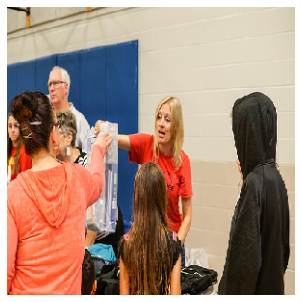

In [848]:
recognized_image, image_topic  = image_recognition_pipeline( )

In [849]:
#image_topic='dragonfly'

In [850]:
#plt.imshow(recognized_image/255.)

## 2 — Generate semantic word families

For each label, use Word2Vec `similar` to retrieve list of words semantically related to the image object labels

In [851]:
from nltk.corpus import wordnet

def get_synonyms( w ):
    #L = [l.name() if '_' not in l.name() else l.name().split('_') for l in wordnet.synsets( w )[0].lemmas()]  # There may be other synonyms in the synset
    #flattened_list = [w if type()]
    #return L #flattened_list
    return [word for object_name in [syn.name().split('_') for syn in wordnet.synsets( w )[0].lemmas()] for word in object_name]

In [852]:
get_synonyms( 'oystercatcher' )

['oystercatcher', 'oyster', 'catcher']

In [853]:
wordnet.synsets( 'oystercatcher' )[0].lemmas()
#get_synonyms( 'ladybug')

[Lemma('oystercatcher.n.01.oystercatcher'),
 Lemma('oystercatcher.n.01.oyster_catcher')]

## 3 — Generate all related words

For each semantically related (below a distance threshold) word to each object label, measure its phonetic similarity to all words in the dictionary. Also store each words's distance.

For each word in each semantic family, sort and choose the phonetically closest (below a distance threshold) words.
(One way is to convert the word to IPA and compare to an IPA converted version of every word in the CMU dictionary.)

In [854]:
#english_dictionary = ['two', 'pair', 'bear', 'scare', 'you', 'twice', 'hair', 'mice', 'speaker', 'book']

In [855]:
# two_phon_fam = Phon_family(locus_word=Close_word('two', 3), close_words = [Close_word('you', 2.1)])
# two_phon_fam

# pair_phon_fam = Phon_family(locus_word=Close_word('pair', 5), close_words = [Close_word('bear', 1.5), Close_word('hair', 2.7)])
# pair_phon_fam

# twice_phon_fam = Phon_family(locus_word=Close_word('twice', 4.1), close_words = [Close_word('mice', 2.1)])
# twice_phon_fam

In [856]:
from nltk.corpus import words

words_set = set( words.words())
english_dictionary = words_set

In [857]:
import eng_to_ipa as ipa

def syllable_count_diff( w1, w2 ):
    return abs( ipa.syllable_count( w1 ) - ipa.syllable_count( w2 ))

def same_syllable_count( w1, w2 ):
    return syllable_count_diff(w1, w2) == 0

def close_syllable_count( w1, w2, threshold=2):
    return syllable_count_diff( w1, w2 ) <= threshold

In [858]:
# Eventually will need to to filter for the word-frequency sweet-spot or at least for only Engllish words
# Possibly rewrite with a decororater so that it uses memoization to speed this up

# Rewrite this so it vectorizes the subtraction of the syllable counts

def get_sized_rhymes( w ):
    word_length_min = 2
    rhyme_list = ipa.get_rhymes( w )
    return [ [rhyme for rhyme  in rhyme_list if same_syllable_count( w, rhyme) and len(rhyme) >= word_length_min and rhyme in words_set]]
   

In [859]:
#ipa.isin_cmu('xue')

In [860]:
get_sized_rhymes('oyster')

[['cloister', 'foister', 'roister']]

In [861]:
import fuzzy
import phonetics
import Levenshtein as lev

soundex = fuzzy.Soundex(4)
dmeta = fuzzy.DMetaphone()

In [862]:
## Temporary stand-in function, to be replaced with one that computes phonetic distance

# https://stackabuse.com/phonetic-similarity-of-words-a-vectorized-approach-in-python/
# "Phonetic Similarity of Words: A Vectorized Approach in Python"

def phonetic_distance(w1, w2):
#     print('fuzzy soundex', lev.distance( soundex(w1), soundex(w2)) )
#     print('fuzzy dmeta  ', lev.distance( dmeta(w1)[0], dmeta(w2)[0]) )
#     print('phon dmet    ', lev.distance( phonetics.dmetaphone(w1)[0], phonetics.dmetaphone(w2)[0]) )
#     print('phon met     ', lev.distance( phonetics.metaphone(w1), phonetics.metaphone(w2)) )
#     print('fuzzy nysiis ', lev.distance( fuzzy.nysiis(w1), fuzzy.nysiis(w2)) )
#     print('phon nysiis  ', lev.distance( phonetics.nysiis(w1), phonetics.nysiis(w2)) )
#     soundex_dist = lev.distance( soundex(w1), soundex(w2))
    nysiis_dist = lev.distance( fuzzy.nysiis(w1), fuzzy.nysiis(w2))
    try:
        dmeta_dist  = lev.distance( dmeta(w1)[0], dmeta(w2)[0])
        return np.mean( np.array([  dmeta_dist, nysiis_dist]) )
    except:
        return nysiis_dist

In [863]:
from random import random


# Are these three lines necessary?
two_fam_member_list = ['you']
pair_fam_member_list = ['bear', 'hair']
twice_fam_member_list = ['mice']

def make_phon_fam_for_sem_fam_member( w_record, thresh=3 ):
    w_phon_code = w_record.word # To be replaced with phonetic version if needed
    close_word_list = []
    
    # Find words that are not necessarily rhyms but phonetically similar
    for word in words_set:
        phon_dist = phonetic_distance( word, w_record.word) 
        if (phon_dist <= thresh) and (word != w_record.word):
            close_word_list.append( Close_word(word.lower(), phon_dist ))
    
    rhyme_dist = .5
    rhyme_word_list = get_sized_rhymes( w_record.word )[0]
    
    # Find words that are rhymes
    for word in rhyme_word_list:
         close_word_list.append( Close_word(word, rhyme_dist) )
    
    
    return Phon_family(locus_word = w_record, close_words=close_word_list )
    
    

In [864]:
# two_phon_fam = get_phon_fam_for_sem_fam_member( 'two' )
# pair_phon_fam = get_phon_fam_for_sem_fam_member( 'pair' )
# twice_phon_fam = get_phon_fam_for_sem_fam_member( 'twice' )


In [865]:
## ALERT:  Need to incorporate the semantic distance somewhere

In [866]:
# two_sem_fam = Sem_family(locus_word='two', phon_fams = [make_phon_fam_for_sem_fam_member( 'two' ), \
#                                                         make_phon_fam_for_sem_fam_member( 'pair' ), \
#                                                         make_phon_fam_for_sem_fam_member( 'twice' )])

In [867]:
# To be replaced with Word2Vec `most_similar()`

def get_most_similar_obsolete( w ):  
    list_of_duples =  [('pair', .95), ('twice', .90)]
    list_of_close_words = [Close_word( word=w_str, distance= 1 - w_sim) for w_str, w_sim in list_of_duples ]
        
    return list_of_close_words

In [868]:
def get_most_similar( w ):  
    synonym_dist_setting = .6
    list_of_duples = [(syn, synonym_dist_setting) for syn in get_synonyms( w )]
    if(w == 'two'):
        additional_words =  [('pair', .95), ('twice', .90)]
        list_of_duples.extend( additional_words )
    list_of_close_words = [Close_word( word=w_str, distance= w_sim) for w_str, w_sim in list_of_duples ]
        
    return list_of_close_words

In [869]:
get_most_similar( 'oyster' )

[Close_word(word='oyster', distance=0.6)]

In [870]:
def make_phon_fams_and_sem_family( w ):
    word_record_ = Close_word(w, 0.0)
    
    sem_sim_words = get_most_similar( w )  # Eventually replace with call to Word2Vec
    
    #phon_fams_list = [make_phon_fam_for_sem_fam_member( word_record_  )]
    phon_fams_list = []

    
    for close_w_record in sem_sim_words:
        print( close_w_record )
        phon_fams_list.append( make_phon_fam_for_sem_fam_member( close_w_record ) )
    
    return Sem_family(locus_word= word_record_, sem_fam_words = phon_fams_list)
   
 

In [871]:
make_phon_fams_and_sem_family('soccer')

Close_word(word='soccer', distance=0.6)
Close_word(word='association', distance=0.6)
Close_word(word='football', distance=0.6)


Sem_family(locus_word=Close_word(word='soccer', distance=0.0), sem_fam_words=[Phon_family(locus_word=Close_word(word='soccer', distance=0.6), close_words=[Close_word(word='hickory', distance=2.0), Close_word(word='rumorous', distance=2.5), Close_word(word='cartier', distance=3.0), Close_word(word='geoduck', distance=3.0), Close_word(word='superhive', distance=2.5), Close_word(word='zincite', distance=3.0), Close_word(word='squacco', distance=2.5), Close_word(word='fictile', distance=3.0), Close_word(word='sarong', distance=3.0), Close_word(word='sexed', distance=2.5), Close_word(word='thecal', distance=2.5), Close_word(word='chudic', distance=3.0), Close_word(word='studium', distance=3.0), Close_word(word='mydaidae', distance=3.0), Close_word(word='phosphoruria', distance=3.0), Close_word(word='stadic', distance=3.0), Close_word(word='sillock', distance=2.0), Close_word(word='gorer', distance=2.0), Close_word(word='somnify', distance=3.0), Close_word(word='ratafia', distance=3.0), Clos

In [872]:
# two_sem_fam = make_phon_fams_and_sem_family('two')
# two_sem_fam

## 4 — Gather candidate phrases

For each word in the phonetic family, of each word in the semantic family, of each object label, retrieve phrases containing the word.
Add the phrase_Id, as well as the stats on the object centrality, semantic distance, and phonetic distance, to a dataframe.

Compute _suitability score_ for each word-phrase match and add this to that column of the dataframe

Also, for each word in the semantic family, search the joke list for match and add that these to a joke_match dataframe, to use if there's too low a suitability score using a substitution.


In [873]:
get_most_similar('soccer')

[Close_word(word='soccer', distance=0.6),
 Close_word(word='association', distance=0.6),
 Close_word(word='football', distance=0.6)]

## TO CODE NEXT

Write code that takes the word `twice` and returns its `semantic_family` which is a list of words 
('pair', and 'twice' in this case) and returns either (TBD) the list phonetically similar words or 
the pboneticized version of the word to be compared with the phoneticized variants of words in
the phrases



#### Define dataframe for candidate phrases

In [874]:
col_names = ['semantic_match', 'sem_dist', 'phonetic_match', 'phon_dist', 'phrase_id', 'score']

cand_df = pd.DataFrame(columns= col_names)
cand_df

Empty DataFrame
Columns: [semantic_match, sem_dist, phonetic_match, phon_dist, phrase_id, score]
Index: []

#### Need to write body of function that will convert to phoneticized version of word

In [875]:
def phoneticized( w ):
    return w

### ALERT:  Instead, pre-generate a dictionary of phoneticized versions of the words in the list of idioms. Each phonetic word should map to a list of duples each of which is a phrase id and the corresponding word

In [876]:
def get_matching_phrases( w ):
    matched_id_list = []
    for phrase_id in phrase_dict.keys():
        if w in phrase_dict[phrase_id].phon_list:
            matched_id_list.append(phrase_id)
            print( phrase_dict[ phrase_id] )
            return matched_id_list

In [877]:
get_matching_phrases('oyster') 

Phrase(text_string='the world is your oyster', word_list=['the', 'world', 'is', 'your', 'oyster'], phon_list=['the', 'world', 'is', 'your', 'oyster'], string_length=24, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')


[UUID('7192dfde-8223-11eb-abae-acde48001122')]

In [878]:
#  cycles through each phonetic family in the semantic family to get matching phrases

#def get_phrases_for_phon_fam( phon_fam_, sem_dist_ ):
def get_phrases_for_phon_fam( phon_fam_ ):

    word_match_records_ = []

    #phon_fam_ = pair_phon_fam
    for word in phon_fam_.close_words:
        matched_phrases = get_matching_phrases( word.word )
        #print(word, len(matched_phrases))
        if matched_phrases:
            for p_id in matched_phrases:
                word_match_records_.append({'semantic_match': phon_fam_.locus_word.word, 'sem_dist': phon_fam_.locus_word.distance, 'phonetic_match': word.word, 'phon_dist': word.distance, 'phrase_id': p_id, 'score': ''})
    return word_match_records_ 


In [879]:
def get_phrases_for_sem_fam( sem_fam_ ):
    word_match_records_ = []
    for phon_fam_ in sem_fam_.sem_fam_words:
        print( phon_fam_.locus_word.distance )
        #word_match_records_.extend( get_phrases_for_phon_fam( phon_fam_, sem_fam_.locus_word.distance ) )
        phrases_ = get_phrases_for_phon_fam( phon_fam_ ) 

        if len( phrases_ ) > 0:
            print( phrases_ )
            word_match_records_.extend( phrases_ )
    return word_match_records_

In [880]:
# word_match_records = []   

# word_match_records.extend( get_phrases_for_phon_fam( two_phon_fam ) ) 
# word_match_records.extend( get_phrases_for_phon_fam( pair_phon_fam ) )
# word_match_records.extend( get_phrases_for_phon_fam( twice_phon_fam ) )  
# word_match_records

In [881]:
#cand_df = cand_df.append(word_match_records)

In [882]:
#two_sem_fam

In [883]:
# word_match_records = get_phrases_for_sem_fam( two_sem_fam )
# word_match_records

In [884]:
# To be replaced with image recognition algorithms
def get_image_topics():
    return [image_topic]
    #return [test_image_topic]

## The equivalent of `main` for the time being, until two or more image topics are handled

In [885]:
image_topics = []
image_topic_word = ''

def generate_the_caption(cand_df_, image_topics_, image_topic_word_):
    image_topics_     = get_image_topics()
    image_topic_word_ = image_topics_[0]
    #image_topic_word = 'boy'

    image_sem_fam = make_phon_fams_and_sem_family( image_topic_word_ )
    #two_sem_fam

    word_match_records = get_phrases_for_sem_fam( image_sem_fam )

    cand_df_ = cand_df_.append(word_match_records)
    return cand_df_, image_topics_, image_topic_word_

cand_df, image_topics, image_topic_word = generate_the_caption(cand_df, image_topics, image_topic_word)

Close_word(word='hair', distance=0.6)
Close_word(word='spray', distance=0.6)
0.6
Phrase(text_string='cast the first stone', word_list=['cast', 'the', 'first', 'stone'], phon_list=['cast', 'the', 'first', 'stone'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='not sit well with (someone)', word_list=['not', 'sit', 'well', 'with', '(someone)'], phon_list=['not', 'sit', 'well', 'with', '(someone)'], string_length=27, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='jump the gun', word_list=['jump', 'the', 'gun'], phon_list=['jump', 'the', 'gun'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sink or swim', word_list=['sink', 'or', 'swim'], phon_list=['sink', 'or', 'swim'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a notch above', word_list=['a', 'notch', 'above'], phon_list=['a', '

Phrase(text_string='Smarter than the average bear', word_list=['smarter', 'than', 'the', 'average', 'bear'], phon_list=['smarter', 'than', 'the', 'average', 'bear'], string_length=29, word_count=5, prefix='As usual: ', phrase_type='idiom')
Phrase(text_string='bang one’s head against the wall (against a brick wall)', word_list=['bang', 'one’s', 'head', 'against', 'the', 'wall', '(against', 'a', 'brick', 'wall)'], phon_list=['bang', 'one’s', 'head', 'against', 'the', 'wall', '(against', 'a', 'brick', 'wall)'], string_length=55, word_count=10, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a week is a long time in', word_list=['a', 'week', 'is', 'a', 'long', 'time', 'in'], phon_list=['a', 'week', 'is', 'a', 'long', 'time', 'in'], string_length=24, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all sizzle and no steak', word_list=['all', 'sizzle', 'and', 'no', 'steak'], phon_list=['all', 'sizzle', 'and', 'no', 'steak'], string_l

Phrase(text_string='not lift a finger', word_list=['not', 'lift', 'a', 'finger'], phon_list=['not', 'lift', 'a', 'finger'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='cut off your nose to spite your face', word_list=['cut', 'off', 'your', 'nose', 'to', 'spite', 'your', 'face'], phon_list=['cut', 'off', 'your', 'nose', 'to', 'spite', 'your', 'face'], string_length=36, word_count=8, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='shoot from the hip', word_list=['shoot', 'from', 'the', 'hip'], phon_list=['shoot', 'from', 'the', 'hip'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='between a rock and a hard place', word_list=['between', 'a', 'rock', 'and', 'a', 'hard', 'place'], phon_list=['between', 'a', 'rock', 'and', 'a', 'hard', 'place'], string_length=31, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='run the 

Phrase(text_string='back the wrong horse', word_list=['back', 'the', 'wrong', 'horse'], phon_list=['back', 'the', 'wrong', 'horse'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='heart and sou', word_list=['heart', 'and', 'sou'], phon_list=['heart', 'and', 'sou'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hobson’s choice', word_list=['hobson’s', 'choice'], phon_list=['hobson’s', 'choice'], string_length=15, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='if it had been a snake, it would have bitten me', word_list=['if', 'it', 'had', 'been', 'a', 'snake,', 'it', 'would', 'have', 'bitten', 'me'], phon_list=['if', 'it', 'had', 'been', 'a', 'snake,', 'it', 'would', 'have', 'bitten', 'me'], string_length=47, word_count=11, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='cash in one’s chips', word_list=['cash', 'in',

Phrase(text_string='cast the first stone', word_list=['cast', 'the', 'first', 'stone'], phon_list=['cast', 'the', 'first', 'stone'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='throw someone under the bus', word_list=['throw', 'someone', 'under', 'the', 'bus'], phon_list=['throw', 'someone', 'under', 'the', 'bus'], string_length=27, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='honor system', word_list=['honor', 'system'], phon_list=['honor', 'system'], string_length=12, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='thank god it’s friday (tgif)', word_list=['thank', 'god', 'it’s', 'friday', '(tgif)'], phon_list=['thank', 'god', 'it’s', 'friday', '(tgif)'], string_length=28, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sick and tired of', word_list=['sick', 'and', 'tired', 'of'], phon_list=['sick', 'and', 'tired'

Phrase(text_string='a bite at the cherry', word_list=['a', 'bite', 'at', 'the', 'cherry'], phon_list=['a', 'bite', 'at', 'the', 'cherry'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='pure as the driven snow', word_list=['pure', 'as', 'the', 'driven', 'snow'], phon_list=['pure', 'as', 'the', 'driven', 'snow'], string_length=23, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a picture is worth a thousand words', word_list=['a', 'picture', 'is', 'worth', 'a', 'thousand', 'words'], phon_list=['a', 'picture', 'is', 'worth', 'a', 'thousand', 'words'], string_length=35, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='high as a kite', word_list=['high', 'as', 'a', 'kite'], phon_list=['high', 'as', 'a', 'kite'], string_length=14, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='give someone a run for their money', word_list=['g

Phrase(text_string='school of hard knocks', word_list=['school', 'of', 'hard', 'knocks'], phon_list=['school', 'of', 'hard', 'knocks'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='act of congress', word_list=['act', 'of', 'congress'], phon_list=['act', 'of', 'congress'], string_length=15, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='too many cooks spoil the broth', word_list=['too', 'many', 'cooks', 'spoil', 'the', 'broth'], phon_list=['too', 'many', 'cooks', 'spoil', 'the', 'broth'], string_length=30, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='your number is up', word_list=['your', 'number', 'is', 'up'], phon_list=['your', 'number', 'is', 'up'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='claim to fame', word_list=['claim', 'to', 'fame'], phon_list=['claim', 'to', 'fame'], string_length=1

Phrase(text_string='bang for your buck', word_list=['bang', 'for', 'your', 'buck'], phon_list=['bang', 'for', 'your', 'buck'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a hundred and ten percent', word_list=['a', 'hundred', 'and', 'ten', 'percent'], phon_list=['a', 'hundred', 'and', 'ten', 'percent'], string_length=25, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='in the nick of time', word_list=['in', 'the', 'nick', 'of', 'time'], phon_list=['in', 'the', 'nick', 'of', 'time'], string_length=19, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='act high and mighty', word_list=['act', 'high', 'and', 'mighty'], phon_list=['act', 'high', 'and', 'mighty'], string_length=19, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bail out', word_list=['bail', 'out'], phon_list=['bail', 'out'], string_length=8, word_count=2, prefi

Phrase(text_string='get someone’s goat', word_list=['get', 'someone’s', 'goat'], phon_list=['get', 'someone’s', 'goat'], string_length=18, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='amber gambler', word_list=['amber', 'gambler'], phon_list=['amber', 'gambler'], string_length=13, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='put that in your pipe and smoke it', word_list=['put', 'that', 'in', 'your', 'pipe', 'and', 'smoke', 'it'], phon_list=['put', 'that', 'in', 'your', 'pipe', 'and', 'smoke', 'it'], string_length=34, word_count=8, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='letter of the law', word_list=['letter', 'of', 'the', 'law'], phon_list=['letter', 'of', 'the', 'law'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='asleep at the wheel (switch)', word_list=['asleep', 'at', 'the', 'wheel', '(switch)'], phon_list=['aslee

Phrase(text_string='come by something honestly', word_list=['come', 'by', 'something', 'honestly'], phon_list=['come', 'by', 'something', 'honestly'], string_length=26, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='any tom, dick or harry', word_list=['any', 'tom,', 'dick', 'or', 'harry'], phon_list=['any', 'tom,', 'dick', 'or', 'harry'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='red meat', word_list=['red', 'meat'], phon_list=['red', 'meat'], string_length=8, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='not give a fig', word_list=['not', 'give', 'a', 'fig'], phon_list=['not', 'give', 'a', 'fig'], string_length=14, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='and so forth', word_list=['and', 'so', 'forth'], phon_list=['and', 'so', 'forth'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_t

Phrase(text_string='armed to the teeth', word_list=['armed', 'to', 'the', 'teeth'], phon_list=['armed', 'to', 'the', 'teeth'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='chuck a wobbly', word_list=['chuck', 'a', 'wobbly'], phon_list=['chuck', 'a', 'wobbly'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='love someone with all of one’s heart and soul', word_list=['love', 'someone', 'with', 'all', 'of', 'one’s', 'heart', 'and', 'soul'], phon_list=['love', 'someone', 'with', 'all', 'of', 'one’s', 'heart', 'and', 'soul'], string_length=45, word_count=9, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='don’t judge a book by its cover', word_list=['don’t', 'judge', 'a', 'book', 'by', 'its', 'cover'], phon_list=['don’t', 'judge', 'a', 'book', 'by', 'its', 'cover'], string_length=31, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(tex

Phrase(text_string='don’t judge a book by its cover', word_list=['don’t', 'judge', 'a', 'book', 'by', 'its', 'cover'], phon_list=['don’t', 'judge', 'a', 'book', 'by', 'its', 'cover'], string_length=31, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='stem the tide', word_list=['stem', 'the', 'tide'], phon_list=['stem', 'the', 'tide'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='pass the buck', word_list=['pass', 'the', 'buck'], phon_list=['pass', 'the', 'buck'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='match made in heaven', word_list=['match', 'made', 'in', 'heaven'], phon_list=['match', 'made', 'in', 'heaven'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='don’t cry over spilled milk', word_list=['don’t', 'cry', 'over', 'spilled', 'milk'], phon_list=['don’t', 'cry', 'over',

Phrase(text_string='your mileage may vary', word_list=['your', 'mileage', 'may', 'vary'], phon_list=['your', 'mileage', 'may', 'vary'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='beauty is only skin deep', word_list=['beauty', 'is', 'only', 'skin', 'deep'], phon_list=['beauty', 'is', 'only', 'skin', 'deep'], string_length=24, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='rob peter to pay paul', word_list=['rob', 'peter', 'to', 'pay', 'paul'], phon_list=['rob', 'peter', 'to', 'pay', 'paul'], string_length=21, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='chickens come home to roost', word_list=['chickens', 'come', 'home', 'to', 'roost'], phon_list=['chickens', 'come', 'home', 'to', 'roost'], string_length=27, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='better late than never', word_list=['better', 'late', 'than

Phrase(text_string='blue eyed boy', word_list=['blue', 'eyed', 'boy'], phon_list=['blue', 'eyed', 'boy'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='food for thought', word_list=['food', 'for', 'thought'], phon_list=['food', 'for', 'thought'], string_length=16, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hail mary (n. or adj.)', word_list=['hail', 'mary', '(n.', 'or', 'adj.)'], phon_list=['hail', 'mary', '(n.', 'or', 'adj.)'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='give one’s two cents (that’s my two cents)', word_list=['give', 'one’s', 'two', 'cents', '(that’s', 'my', 'two', 'cents)'], phon_list=['give', 'one’s', 'two', 'cents', '(that’s', 'my', 'two', 'cents)'], string_length=42, word_count=8, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='don’t judge a book by its cover', word_list=['don’t', 'judg

Phrase(text_string='all very well', word_list=['all', 'very', 'well'], phon_list=['all', 'very', 'well'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sneak peek', word_list=['sneak', 'peek'], phon_list=['sneak', 'peek'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='beyond the shadow of a doubt', word_list=['beyond', 'the', 'shadow', 'of', 'a', 'doubt'], phon_list=['beyond', 'the', 'shadow', 'of', 'a', 'doubt'], string_length=28, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a lot on one’s plate', word_list=['a', 'lot', 'on', 'one’s', 'plate'], phon_list=['a', 'lot', 'on', 'one’s', 'plate'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='Smarter than the average bear', word_list=['smarter', 'than', 'the', 'average', 'bear'], phon_list=['smarter', 'than', 'the', 'average', 'bear'

Phrase(text_string='simmer down', word_list=['simmer', 'down'], phon_list=['simmer', 'down'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='tie the knot', word_list=['tie', 'the', 'knot'], phon_list=['tie', 'the', 'knot'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='as poor as a church mouse', word_list=['as', 'poor', 'as', 'a', 'church', 'mouse'], phon_list=['as', 'poor', 'as', 'a', 'church', 'mouse'], string_length=25, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='run a tight ship', word_list=['run', 'a', 'tight', 'ship'], phon_list=['run', 'a', 'tight', 'ship'], string_length=16, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bend an elbow', word_list=['bend', 'an', 'elbow'], phon_list=['bend', 'an', 'elbow'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
P

Phrase(text_string='like father, like son', word_list=['like', 'father,', 'like', 'son'], phon_list=['like', 'father,', 'like', 'son'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bend an elbow', word_list=['bend', 'an', 'elbow'], phon_list=['bend', 'an', 'elbow'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all fur coat and no knickers', word_list=['all', 'fur', 'coat', 'and', 'no', 'knickers'], phon_list=['all', 'fur', 'coat', 'and', 'no', 'knickers'], string_length=28, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='is the pope catholic?', word_list=['is', 'the', 'pope', 'catholic?'], phon_list=['is', 'the', 'pope', 'catholic?'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='couch potato', word_list=['couch', 'potato'], phon_list=['couch', 'potato'], string_length=12, word_c

Phrase(text_string='like a kid in a candy store', word_list=['like', 'a', 'kid', 'in', 'a', 'candy', 'store'], phon_list=['like', 'a', 'kid', 'in', 'a', 'candy', 'store'], string_length=27, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='love rat', word_list=['love', 'rat'], phon_list=['love', 'rat'], string_length=8, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='that’s all she wrote', word_list=['that’s', 'all', 'she', 'wrote'], phon_list=['that’s', 'all', 'she', 'wrote'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='spin a yarn', word_list=['spin', 'a', 'yarn'], phon_list=['spin', 'a', 'yarn'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all over but the shouting', word_list=['all', 'over', 'but', 'the', 'shouting'], phon_list=['all', 'over', 'but', 'the', 'shouting'], string_length=25, word_co

Phrase(text_string='chuck a wobbly', word_list=['chuck', 'a', 'wobbly'], phon_list=['chuck', 'a', 'wobbly'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='ball and chain', word_list=['ball', 'and', 'chain'], phon_list=['ball', 'and', 'chain'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='cat’s paw', word_list=['cat’s', 'paw'], phon_list=['cat’s', 'paw'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='have one’s cake and eat it, too', word_list=['have', 'one’s', 'cake', 'and', 'eat', 'it,', 'too'], phon_list=['have', 'one’s', 'cake', 'and', 'eat', 'it,', 'too'], string_length=31, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='not ready for prime time', word_list=['not', 'ready', 'for', 'prime', 'time'], phon_list=['not', 'ready', 'for', 'prime', 'time'], string_length=24, word_count

Phrase(text_string='as american as apple pie', word_list=['as', 'american', 'as', 'apple', 'pie'], phon_list=['as', 'american', 'as', 'apple', 'pie'], string_length=24, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a penny for your thoughts', word_list=['a', 'penny', 'for', 'your', 'thoughts'], phon_list=['a', 'penny', 'for', 'your', 'thoughts'], string_length=25, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='cast the first stone', word_list=['cast', 'the', 'first', 'stone'], phon_list=['cast', 'the', 'first', 'stone'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a stone’s throw', word_list=['a', 'stone’s', 'throw'], phon_list=['a', 'stone’s', 'throw'], string_length=15, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sneak peek', word_list=['sneak', 'peek'], phon_list=['sneak', 'peek'], string_length=10, word_coun

Phrase(text_string='belly laugh', word_list=['belly', 'laugh'], phon_list=['belly', 'laugh'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='spit into the wind', word_list=['spit', 'into', 'the', 'wind'], phon_list=['spit', 'into', 'the', 'wind'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string="Wouldn't it be nice", word_list=["wouldn't", 'it', 'be', 'nice'], phon_list=["wouldn't", 'it', 'be', 'nice'], string_length=19, word_count=4, prefix='As usual: ', phrase_type='idiom')
Phrase(text_string='bad egg', word_list=['bad', 'egg'], phon_list=['bad', 'egg'], string_length=7, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='blow one’s top', word_list=['blow', 'one’s', 'top'], phon_list=['blow', 'one’s', 'top'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='no names, no pack drill', word_li

Phrase(text_string='all wet', word_list=['all', 'wet'], phon_list=['all', 'wet'], string_length=7, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all over hell’s half acre', word_list=['all', 'over', 'hell’s', 'half', 'acre'], phon_list=['all', 'over', 'hell’s', 'half', 'acre'], string_length=25, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a lame duck', word_list=['a', 'lame', 'duck'], phon_list=['a', 'lame', 'duck'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='spare the rod and spoil the child', word_list=['spare', 'the', 'rod', 'and', 'spoil', 'the', 'child'], phon_list=['spare', 'the', 'rod', 'and', 'spoil', 'the', 'child'], string_length=33, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='stand (someone) in good stead', word_list=['stand', '(someone)', 'in', 'good', 'stead'], phon_list=['stand', '(someone)', '

Phrase(text_string='worn to a frazzle', word_list=['worn', 'to', 'a', 'frazzle'], phon_list=['worn', 'to', 'a', 'frazzle'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='at the end of one’s rope (tether)', word_list=['at', 'the', 'end', 'of', 'one’s', 'rope', '(tether)'], phon_list=['at', 'the', 'end', 'of', 'one’s', 'rope', '(tether)'], string_length=33, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a little from column a, a little from column b', word_list=['a', 'little', 'from', 'column', 'a,', 'a', 'little', 'from', 'column', 'b'], phon_list=['a', 'little', 'from', 'column', 'a,', 'a', 'little', 'from', 'column', 'b'], string_length=46, word_count=10, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='Up, up in the air', word_list=['up,', 'up', 'in', 'the', 'air'], phon_list=['up,', 'up', 'in', 'the', 'air'], string_length=17, word_count=5, prefix='As usual: ', phrase

Phrase(text_string='after the lord mayor’s show (uk)', word_list=['after', 'the', 'lord', 'mayor’s', 'show', '(uk)'], phon_list=['after', 'the', 'lord', 'mayor’s', 'show', '(uk)'], string_length=32, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='beat someone to the draw', word_list=['beat', 'someone', 'to', 'the', 'draw'], phon_list=['beat', 'someone', 'to', 'the', 'draw'], string_length=24, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all sizzle and no steak', word_list=['all', 'sizzle', 'and', 'no', 'steak'], phon_list=['all', 'sizzle', 'and', 'no', 'steak'], string_length=23, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='cry over spilt (usa: spilled)', word_list=['cry', 'over', 'spilt', '(usa:', 'spilled)'], phon_list=['cry', 'over', 'spilt', '(usa:', 'spilled)'], string_length=29, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a 

Phrase(text_string='swan song', word_list=['swan', 'song'], phon_list=['swan', 'song'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='i’ve had it up to here', word_list=['i’ve', 'had', 'it', 'up', 'to', 'here'], phon_list=['i’ve', 'had', 'it', 'up', 'to', 'here'], string_length=22, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='pet peeve', word_list=['pet', 'peeve'], phon_list=['pet', 'peeve'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='push the envelope', word_list=['push', 'the', 'envelope'], phon_list=['push', 'the', 'envelope'], string_length=17, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bet one’s bottom dollar (on something)', word_list=['bet', 'one’s', 'bottom', 'dollar', '(on', 'something)'], phon_list=['bet', 'one’s', 'bottom', 'dollar', '(on', 'something)'], string_length=38, word_cou

Phrase(text_string='sell (someone) a bill of goods', word_list=['sell', '(someone)', 'a', 'bill', 'of', 'goods'], phon_list=['sell', '(someone)', 'a', 'bill', 'of', 'goods'], string_length=30, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sick and tired of', word_list=['sick', 'and', 'tired', 'of'], phon_list=['sick', 'and', 'tired', 'of'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='lower the boom', word_list=['lower', 'the', 'boom'], phon_list=['lower', 'the', 'boom'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sacred cow', word_list=['sacred', 'cow'], phon_list=['sacred', 'cow'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a bite at the cherry', word_list=['a', 'bite', 'at', 'the', 'cherry'], phon_list=['a', 'bite', 'at', 'the', 'cherry'], string_length=20, word_count=5

Phrase(text_string='speak of the devil (and he shall appear)', word_list=['speak', 'of', 'the', 'devil', '(and', 'he', 'shall', 'appear)'], phon_list=['speak', 'of', 'the', 'devil', '(and', 'he', 'shall', 'appear)'], string_length=40, word_count=8, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='come rain and shine', word_list=['come', 'rain', 'and', 'shine'], phon_list=['come', 'rain', 'and', 'shine'], string_length=19, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='belly laugh', word_list=['belly', 'laugh'], phon_list=['belly', 'laugh'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='rain on someone’s parade', word_list=['rain', 'on', 'someone’s', 'parade'], phon_list=['rain', 'on', 'someone’s', 'parade'], string_length=24, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='the time is ripe', word_list=['the', 'time', 'is', 'ripe'], ph

Phrase(text_string='flash in the pan', word_list=['flash', 'in', 'the', 'pan'], phon_list=['flash', 'in', 'the', 'pan'], string_length=16, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bar fly (or barfly)', word_list=['bar', 'fly', '(or', 'barfly)'], phon_list=['bar', 'fly', '(or', 'barfly)'], string_length=19, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='as american as apple pie', word_list=['as', 'american', 'as', 'apple', 'pie'], phon_list=['as', 'american', 'as', 'apple', 'pie'], string_length=24, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='get one’s ducks in a row', word_list=['get', 'one’s', 'ducks', 'in', 'a', 'row'], phon_list=['get', 'one’s', 'ducks', 'in', 'a', 'row'], string_length=24, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hail mary (n. or adj.)', word_list=['hail', 'mary', '(n.', 'or', 'adj.)'], phon_list=['ha

Phrase(text_string='your mileage may vary', word_list=['your', 'mileage', 'may', 'vary'], phon_list=['your', 'mileage', 'may', 'vary'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='beauty is only skin deep', word_list=['beauty', 'is', 'only', 'skin', 'deep'], phon_list=['beauty', 'is', 'only', 'skin', 'deep'], string_length=24, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='rob peter to pay paul', word_list=['rob', 'peter', 'to', 'pay', 'paul'], phon_list=['rob', 'peter', 'to', 'pay', 'paul'], string_length=21, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='fall prey to', word_list=['fall', 'prey', 'to'], phon_list=['fall', 'prey', 'to'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='best (greatest) thing since sliced bread', word_list=['best', '(greatest)', 'thing', 'since', 'sliced', 'bread'], ph

Phrase(text_string='sold on (something)', word_list=['sold', 'on', '(something)'], phon_list=['sold', 'on', '(something)'], string_length=19, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='in for a penny, in for a pound', word_list=['in', 'for', 'a', 'penny,', 'in', 'for', 'a', 'pound'], phon_list=['in', 'for', 'a', 'penny,', 'in', 'for', 'a', 'pound'], string_length=30, word_count=8, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bang for your buck', word_list=['bang', 'for', 'your', 'buck'], phon_list=['bang', 'for', 'your', 'buck'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='an early bird', word_list=['an', 'early', 'bird'], phon_list=['an', 'early', 'bird'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='keep a stiff upper lip', word_list=['keep', 'a', 'stiff', 'upper', 'lip'], phon_list=['keep', 'a', 'stif

Phrase(text_string='bitter pill to swallow', word_list=['bitter', 'pill', 'to', 'swallow'], phon_list=['bitter', 'pill', 'to', 'swallow'], string_length=22, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='zig when one should be zagging', word_list=['zig', 'when', 'one', 'should', 'be', 'zagging'], phon_list=['zig', 'when', 'one', 'should', 'be', 'zagging'], string_length=30, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='slip someone a mickey', word_list=['slip', 'someone', 'a', 'mickey'], phon_list=['slip', 'someone', 'a', 'mickey'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='go cold turkey', word_list=['go', 'cold', 'turkey'], phon_list=['go', 'cold', 'turkey'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bull in a china shop', word_list=['bull', 'in', 'a', 'china', 'shop'], phon_list=['bull',

Phrase(text_string='throw the baby out with the bath water', word_list=['throw', 'the', 'baby', 'out', 'with', 'the', 'bath', 'water'], phon_list=['throw', 'the', 'baby', 'out', 'with', 'the', 'bath', 'water'], string_length=38, word_count=8, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='put a thumb on the scale', word_list=['put', 'a', 'thumb', 'on', 'the', 'scale'], phon_list=['put', 'a', 'thumb', 'on', 'the', 'scale'], string_length=24, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='pipped to the post', word_list=['pipped', 'to', 'the', 'post'], phon_list=['pipped', 'to', 'the', 'post'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='break out in a cold sweat', word_list=['break', 'out', 'in', 'a', 'cold', 'sweat'], phon_list=['break', 'out', 'in', 'a', 'cold', 'sweat'], string_length=25, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_s

Phrase(text_string='all over but the shouting', word_list=['all', 'over', 'but', 'the', 'shouting'], phon_list=['all', 'over', 'but', 'the', 'shouting'], string_length=25, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='spit into the wind', word_list=['spit', 'into', 'the', 'wind'], phon_list=['spit', 'into', 'the', 'wind'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='blow one’s top', word_list=['blow', 'one’s', 'top'], phon_list=['blow', 'one’s', 'top'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='no names, no pack drill', word_list=['no', 'names,', 'no', 'pack', 'drill'], phon_list=['no', 'names,', 'no', 'pack', 'drill'], string_length=23, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='flat broke', word_list=['flat', 'broke'], phon_list=['flat', 'broke'], string_length=10, word_count=2, prefix=

Phrase(text_string='cut someone some slack', word_list=['cut', 'someone', 'some', 'slack'], phon_list=['cut', 'someone', 'some', 'slack'], string_length=22, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='carry a torch (for)', word_list=['carry', 'a', 'torch', '(for)'], phon_list=['carry', 'a', 'torch', '(for)'], string_length=19, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='cheap shot', word_list=['cheap', 'shot'], phon_list=['cheap', 'shot'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sticky wicket', word_list=['sticky', 'wicket'], phon_list=['sticky', 'wicket'], string_length=13, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='red tape', word_list=['red', 'tape'], phon_list=['red', 'tape'], string_length=8, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a storm in a teacup',

In [886]:
image_sem_fam.sem_fam_words[0]

Phon_family(locus_word=Close_word(word='accordion', distance=0), close_words=[Close_word(word='kowagmiut', distance=3.0), Close_word(word='hickory', distance=3.0), Close_word(word='cartier', distance=2.0), Close_word(word='auximone', distance=2.5), Close_word(word='agoranome', distance=2.0), Close_word(word='costume', distance=3.0), Close_word(word='acrimonious', distance=2.5), Close_word(word='gorer', distance=3.0), Close_word(word='odorize', distance=3.0), Close_word(word='niggardly', distance=2.5), Close_word(word='cauda', distance=3.0), Close_word(word='cutaway', distance=3.0), Close_word(word='cerci', distance=3.0), Close_word(word='skirret', distance=2.0), Close_word(word='agnation', distance=3.0), Close_word(word='agnoete', distance=3.0), Close_word(word='acromial', distance=3.0), Close_word(word='peratae', distance=3.0), Close_word(word='lordliness', distance=3.0), Close_word(word='secant', distance=3.0), Close_word(word='bipartile', distance=3.0), Close_word(word='afrogaea', d

In [887]:
test_sem_fam_word = image_sem_fam.sem_fam_words[1]
test_sem_fam_word

Phon_family(locus_word=Close_word(word='piano', distance=0), close_words=[Close_word(word='reg', distance=2.0), Close_word(word='ghetto', distance=2.0), Close_word(word='parnas', distance=1.5), Close_word(word='breton', distance=3.0), Close_word(word='squacco', distance=3.0), Close_word(word='vise', distance=2.0), Close_word(word='ray', distance=2.5), Close_word(word='porcine', distance=2.5), Close_word(word='unmeant', distance=3.0), Close_word(word='olla', distance=2.5), Close_word(word='pea', distance=1.5), Close_word(word='bessie', distance=2.0), Close_word(word='luo', distance=2.5), Close_word(word='toumnah', distance=1.5), Close_word(word='whipman', distance=2.5), Close_word(word='compony', distance=3.0), Close_word(word='pleonasm', distance=3.0), Close_word(word='quark', distance=3.0), Close_word(word='stey', distance=2.5), Close_word(word='tice', distance=2.0), Close_word(word='spinder', distance=3.0), Close_word(word='cauda', distance=2.0), Close_word(word='finesse', distance=2

In [888]:
test_sem_fam_word.close_words

[Close_word(word='reg', distance=2.0),
 Close_word(word='ghetto', distance=2.0),
 Close_word(word='parnas', distance=1.5),
 Close_word(word='breton', distance=3.0),
 Close_word(word='squacco', distance=3.0),
 Close_word(word='vise', distance=2.0),
 Close_word(word='ray', distance=2.5),
 Close_word(word='porcine', distance=2.5),
 Close_word(word='unmeant', distance=3.0),
 Close_word(word='olla', distance=2.5),
 Close_word(word='pea', distance=1.5),
 Close_word(word='bessie', distance=2.0),
 Close_word(word='luo', distance=2.5),
 Close_word(word='toumnah', distance=1.5),
 Close_word(word='whipman', distance=2.5),
 Close_word(word='compony', distance=3.0),
 Close_word(word='pleonasm', distance=3.0),
 Close_word(word='quark', distance=3.0),
 Close_word(word='stey', distance=2.5),
 Close_word(word='tice', distance=2.0),
 Close_word(word='spinder', distance=3.0),
 Close_word(word='cauda', distance=2.0),
 Close_word(word='finesse', distance=2.5),
 Close_word(word='summate', distance=3.0),
 Cl

In [889]:
get_sized_rhymes('soccer')

[['blocker',
  'clocker',
  'cocker',
  'crocker',
  'docker',
  'hocker',
  'laugher',
  'locker',
  'rocker',
  'shocker',
  'stocker']]

In [890]:
test_sem_fam_word.close_words[0].word

'reg'

In [891]:
print( get_matching_phrases( 'life') )

Phrase(text_string='a life of its own', word_list=['a', 'life', 'of', 'its', 'own'], phon_list=['a', 'life', 'of', 'its', 'own'], string_length=17, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
[UUID('719213ec-8223-11eb-abae-acde48001122')]


In [892]:
print( get_matching_phrases( test_sem_fam_word.close_words[0].word ) )

None


In [893]:
image_sem_fam.sem_fam_words[2]

Phon_family(locus_word=Close_word(word='accordion', distance=0), close_words=[Close_word(word='kowagmiut', distance=3.0), Close_word(word='hickory', distance=3.0), Close_word(word='cartier', distance=2.0), Close_word(word='auximone', distance=2.5), Close_word(word='agoranome', distance=2.0), Close_word(word='costume', distance=3.0), Close_word(word='acrimonious', distance=2.5), Close_word(word='gorer', distance=3.0), Close_word(word='odorize', distance=3.0), Close_word(word='niggardly', distance=2.5), Close_word(word='cauda', distance=3.0), Close_word(word='cutaway', distance=3.0), Close_word(word='cerci', distance=3.0), Close_word(word='skirret', distance=2.0), Close_word(word='agnation', distance=3.0), Close_word(word='agnoete', distance=3.0), Close_word(word='acromial', distance=3.0), Close_word(word='peratae', distance=3.0), Close_word(word='lordliness', distance=3.0), Close_word(word='secant', distance=3.0), Close_word(word='bipartile', distance=3.0), Close_word(word='afrogaea', d

In [894]:
# cand_df = pd.DataFrame({"semantic_match": ['pair','pair','twice'], "sem_dist": [5, 5, 4.1], "phonetic_match": ['bear', 'hair','mice'], "phon_dist": [1.5, 2.7, 2.1], "phrase_id":  [ph_id1, ph_id2,ph_id3], "phrase_type":  ['idiom', 'idiom','idiom'],'score': [.5, .3, 1.1]})


In [895]:
cand_df

semantic_match  sem_dist phonetic_match  phon_dist  \
0              hair       0.6          stone        3.0   
1              hair       0.6            sit        2.0   
2              hair       0.6            gun        2.0   
3              hair       0.6           swim        2.5   
4              hair       0.6          notch        3.0   
...             ...       ...            ...        ...   
1557          spray       0.6           prey        0.5   
1558          spray       0.6            say        0.5   
1559          spray       0.6           stay        0.5   
1560          spray       0.6           they        0.5   
1561          spray       0.6            way        0.5   

                                 phrase_id score  
0     71924948-8223-11eb-abae-acde48001122        
1     7192a154-8223-11eb-abae-acde48001122        
2     71928a70-8223-11eb-abae-acde48001122        
3     7192c3f0-8223-11eb-abae-acde48001122        
4     719214f0-8223-11eb-abae-acde48001122        
...                                    ...   ...  
1557  7192611c-8223-11eb-abae-acde48001122        
1558  718fbee4-8223-11eb-abae-acde48001122        
1559  7192de76-8223-11eb-abae-acde48001122        
1560  7192de76-8223-11eb-abae-acde48001122        
1561  71929416-8223-11eb-abae-acde48001122        

[1562 rows x 6 columns]

In [896]:
def compute_candidate_caption_scores():
    cand_df['score'] = cand_df.apply(lambda row: row['sem_dist'] + row['phon_dist'], axis=1)
    cand_df
    
compute_candidate_caption_scores()

## 5 —  Choose captions

Sort captions dataframe by the _suitability score_

Choose the top 10(?) and generate a list containing each caption with the original semantic family word substituted into the idiom in addition to jokes containing any of the semantic family words

In [897]:
def sub_raw_string(phrase_string, orig_word='', new_word=''):
    return phrase_string.replace(orig_word, new_word)

In [898]:
def sub(phrase, orig_word='', new_word=''):
    return phrase.text_string.replace(orig_word, new_word)

In [899]:
phrase_string = 'Wild Goose Chase'
sub_raw_string(phrase_string, 'wild', 'child')

'Wild Goose Chase'

In [900]:
def construct_caption( row ):
    return sub( phrase_dict[ row['phrase_id']], row['phonetic_match'],  row['semantic_match']  )

In [901]:
def get_best_captions(df, selection_size=10):
    df.sort_values(by='score', inplace=True)
    best_df = df.head(selection_size)
    #best_df['caption'] = best_df.apply(construct_caption, axis=1 )
    best_df.loc[:, 'caption'] = best_df.apply(construct_caption, axis=1 ) 
    return best_df
    #return best_df['_caption'].to_list()

In [902]:

cand_df

semantic_match  sem_dist phonetic_match  phon_dist  \
0              hair       0.6          stone        3.0   
1              hair       0.6            sit        2.0   
2              hair       0.6            gun        2.0   
3              hair       0.6           swim        2.5   
4              hair       0.6          notch        3.0   
...             ...       ...            ...        ...   
1557          spray       0.6           prey        0.5   
1558          spray       0.6            say        0.5   
1559          spray       0.6           stay        0.5   
1560          spray       0.6           they        0.5   
1561          spray       0.6            way        0.5   

                                 phrase_id  score  
0     71924948-8223-11eb-abae-acde48001122    3.6  
1     7192a154-8223-11eb-abae-acde48001122    2.6  
2     71928a70-8223-11eb-abae-acde48001122    2.6  
3     7192c3f0-8223-11eb-abae-acde48001122    3.1  
4     719214f0-8223-11eb-abae-acde48001122    3.6  
...                                    ...    ...  
1557  7192611c-8223-11eb-abae-acde48001122    1.1  
1558  718fbee4-8223-11eb-abae-acde48001122    1.1  
1559  7192de76-8223-11eb-abae-acde48001122    1.1  
1560  7192de76-8223-11eb-abae-acde48001122    1.1  
1561  71929416-8223-11eb-abae-acde48001122    1.1  

[1562 rows x 6 columns]

In [903]:
def process_best_captions_df_and_make_list(cand_df):
    best_captions_df = get_best_captions(cand_df)
    best_captions_df
    best_captions_list = [caption.capitalize() for caption in best_captions_df['caption'].to_list()]
    return best_captions_df, best_captions_list

In [904]:
best_captions_df, best_captions_list = process_best_captions_df_and_make_list(cand_df)


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [905]:
best_captions_df

semantic_match  sem_dist phonetic_match  phon_dist  \
783            hair       0.6           hour        0.0   
115            hair       0.6           here        0.0   
981            hair       0.6           hear        0.0   
1064           hair       0.6          spare        0.5   
1063           hair       0.6          share        0.5   
1062           hair       0.6          scare        0.5   
1061           hair       0.6           rare        0.5   
1060           hair       0.6         prayer        0.5   
1059           hair       0.6           fair        0.5   
1058           hair       0.6           bear        0.5   

                                 phrase_id  score  \
783   71922364-8223-11eb-abae-acde48001122    0.6   
115   71928958-8223-11eb-abae-acde48001122    0.6   
981   71927d1e-8223-11eb-abae-acde48001122    0.6   
1064  7192c8be-8223-11eb-abae-acde48001122    1.1   
1063  719292d6-8223-11eb-abae-acde48001122    1.1   
1062  7192bc34-8223-11eb-abae-acde48001122    1.1   
1061  719215ae-8223-11eb-abae-acde48001122    1.1   
1060  7192a05a-8223-11eb-abae-acde48001122    1.1   
1059  7192dbe2-8223-11eb-abae-acde48001122    1.1   
1058  718fbdae-8223-11eb-abae-acde48001122    1.1   

                                       caption  
783                               amateur hair  
115                     i’ve had it up to hair  
981     hair (something) through the grapevine  
1064          hair the rod and spoil the child  
1063                               lion’s hair  
1062  hair the living daylights out of someone  
1061                               a hair bird  
1060                           not have a hair  
1059                    turnabout is hair play  
1058             Smarter than the average hair

In [906]:
import matplotlib.image as mpimg
img = mpimg.imread('data/temp.png')

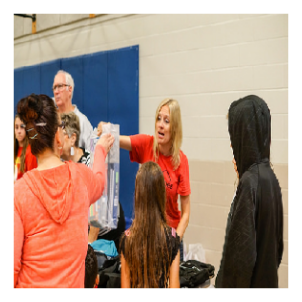

In [907]:
ax = plt.axes([0,0,1,1], frameon=False)

# Then we disable our xaxis and yaxis completely. If we just say plt.axis('off'),
# they are still used in the computation of the image padding.
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Even though our axes (plot region) are set to cover the whole image with [0,0,1,1],
# by default they leave padding between the plotted data and the frame. We use tigher=True
# to make sure the data gets scaled to the full extents of the axes.
plt.autoscale(tight=True)

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

#plt.imshow(recognized_image/255.)
#plt.imshow(global_var_img/255.)
plt.imshow(img)


In [908]:
best_captions_list 

['Amateur hair',
 'I’ve had it up to hair',
 'Hair (something) through the grapevine',
 'Hair the rod and spoil the child',
 'Lion’s hair',
 'Hair the living daylights out of someone',
 'A hair bird',
 'Not have a hair',
 'Turnabout is hair play',
 'Smarter than the average hair']

In [909]:
image_topic

'hair_spray'

In [910]:
def make_image_with_caption( image, caption):
  ax = plt.subplot(1, 1, 1)
  plt.axis('off')
  plt.text( 0.5, -0.1, caption, \
    horizontalalignment='center', verticalalignment='center', \
    transform=ax.transAxes, fontsize=16)
  plt.imshow( image)

  plt.tight_layout()
  plt.savefig('data/image_with_caption.png')
  plt.show()





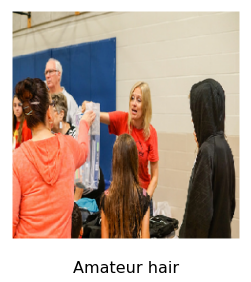

In [911]:
longer_caption = 'Box in the henhouse (chickenhouse) Box in the henhouse (chickenhouse)'
#plot_image( img, longer_caption)

make_image_with_caption( img, best_captions_list[0])